# Challenge: 
***ULMFiT Sentiment: Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment***

# Approach:

*The approach will be a two way approach, at first we will try out various supervised learning algorithms and then tey to compare their performances with semi-supervised ULMFit Model.*



**Contents**

> The structure of the notebook is as follows:


*   Load Data
*   Exploratory Data Analysis
*   **Supervised Learning**
1.  Data Cleaning & Wrangling
2.  Feature Engineering
3.  Model Fit and Predictions
4.  Result Summary
*   **Semi - Supervised Learning : ULMFit**
1. Preparing the data for the Language Model
2. Language Model
3. Training & Testing the Classifier
4. Result Summary







# Load Data

In [ ]:
#loading the libraries
import pandas as pd
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

# For visualizations
import matplotlib.pyplot as plt
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math

In [ ]:
df = pd.read_csv('Tweets.csv')
df.head(3)

In [ ]:
df.isnull().sum()

In [ ]:
print("Percentage null or na values in df")
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

In [ ]:
#Rejecting columns that have NAN values > 90%
df_new = df.drop(columns=['airline_sentiment_gold','negativereason_gold','tweet_coord'])
df_new.isnull().sum()

In [ ]:
df_new.shape

In [ ]:
#Examining a few Tweets
print('Tweet Sentiment :',df_new['airline_sentiment'][1])
print('Tweet :',df_new['text'][1])

In [ ]:
#Examining a few Tweets
print('Tweet Sentiment :',df_new['airline_sentiment'][0])
print('Tweet :',df_new['text'][0])

In [ ]:
#Examining a few Tweets
print('Tweet Sentiment :',df_new['airline_sentiment'][5])
print('Tweet :',df_new['text'][5])

So we have three types of Tweets. The Tweets are not in the proper format so we need to clear them out

# Exploratory Data Analysis

Exploratory Data Analysis is a process by which we can get an overview of the dataset. Before starting with this dataset we will try to study the dataset.

In [ ]:
#Print out the company names in a list
companies = list(df_new['airline'].unique())
print(companies)

In [ ]:
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
#airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
airlines = companies
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)


**Examining the most used words**

In [ ]:
from wordcloud import WordCloud,STOPWORDS

In [ ]:
new_df=df[df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [ ]:
new_df=df[df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
#get the number of negative reasons
df['negativereason'].nunique()

NR_Count=dict(df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=df
    else:
        a=df[df['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame
def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

#Supervised Learning

Firstly we will try the classic supervised learning approaches like LogisticRegression, RandomForest, DecisionTree Classifiers.

# Data Cleaning & Wrangling

In [ ]:

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)



Since the tweets contain a lot of tagged user names, money amounts and number so to keep the meaning of them intact let's replace them with meaningful words.

All Company names -> company

All User Names -> name

Money amount -> money

Number -> number

This will also prevent the model from getting biased towards a particular airlines as our sole reason is to do analysis on the tweets.

In [ ]:
#Replace the Twitter handles with tags
def replace_tags(df_new):
  company_list = ['@VirginAmerica','@AmericanAir','@USAirways','@usairw','@USAirw','@usairways','@JetBlue','@jetBlue','@SouthwestAir','@united']
  for ind in df_new.index:
    s = df_new['text'][ind]
    s1 = ch = ""
    w = s.split(' ')
    #print(w)
    for i in range(len(w)):
      try:
        if w[i][0] == '@':
          if w[i] in company_list:
            ch = 'Company'
          else:
            ch = 'Name'
        elif w[i][0] == '$' :
            ch = 'money'
        elif (w[i][0].isdigit()):
            ch = 'number'
        else:
          ch = w[i]
      except:
        a =0
      s1 = s1 + " " + ch
    df_new['text'][ind] = s1

  return df_new


In [ ]:
#Examining a few Tweets
print('Before Data Wrangling')
print('Tweet Sentiment :',df_new['airline_sentiment'][5])
print('Tweet :',df_new['text'][5])

In [ ]:
def data_wrangling(df_new):
  # Expanding Contractions in the reviews
  df_new['text']=df_new['text'].apply(lambda x:expand_contractions(x))
  print('Contractions expanded !')
  df_new = replace_tags(df_new)
  print('Profile Tags replaced !')

data_wrangling(df_new)

In [ ]:
#Examining a few Tweets
print('After Replacements')
print('Tweet Sentiment :',df_new['airline_sentiment'][5])
print('Tweet :',df_new['text'][5])

In [ ]:
#Print out the company names in a list
l = list(df_new['airline'].unique())
print(l)

This makes sense now 

In [ ]:
#df_new['text']=df_new['text'].apply(lambda x: x.lower())
df_new['text']=df_new['text'].apply(lambda x: re.sub('\w*\d\w*','', x))
#Removing Punctuations
df_new['text']=df_new['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
#Removing extra spaces
df_new['text']=df_new['text'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
#Examining a few Tweets
print('After Data Cleaning')
print('Tweet Sentiment :',df_new['airline_sentiment'][5])
print('Tweet :',df_new['text'][5])

In [ ]:
#df_new.to_csv('tweets_cleaned.csv')

# Feature Engineering

Creating features out of the dataset

In [ ]:
#list of columns
df_new.isnull().sum()

For creating the feature columns we select 

**Creating Text Based Features**

In [ ]:
#taking only the text data column lets try to do Feature Engineering on this
text_features = df_new[['text']]
text_features.head(3)

In [ ]:
import string

text_features['char_count'] = text_features['text'].apply(len)
text_features['word_count'] = text_features['text'].apply(lambda x: len(x.split()))
text_features['word_density'] = text_features['char_count'] / (text_features['word_count']+1)
#text_features['punctuation_count'] = text_features['Review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
text_features['title_word_count'] = text_features['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
text_features['upper_case_word_count'] = text_features['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


In [ ]:
text_features.head(5)

 **Feature extraction with TextBlob**

When doing a sentiment analysis we are trying to determine the attitude or the emotion of the person who is writing the review whether the writing is positive, negative or neutral.

TextBlob has a feature for calculating **polarity** and **subjectivity** of the writing. 

Polarity is a value that ranges from [-1,1] where -1 denotes negative and +1 denotes positive. 
Subjectivity refers to personal opinions, emotion or judgement. This is also a float value and ranges between [0,1]

In [ ]:
import textblob

In [ ]:
#Lets try it out on some reviews
p = "@VirginAmerica plus you've added commercials to the experience... tacky."
print(textblob.TextBlob(p).sentiment)
n = "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA"
print(textblob.TextBlob(n).sentiment)
nn = "@VirginAmerica What @dhepburn said."
print(textblob.TextBlob(nn).sentiment)

The second review has a negative polarity which shows that it is a negative review (which is right) rest of the reviews are classified as neutral. 

This polarity and subjectivity can be added as a feature of this the dataset

In [ ]:
sentiment_obj = text_features['text'].apply(lambda row: textblob.TextBlob(row).sentiment)
text_features['Polarity'] = [obj.polarity for obj in sentiment_obj.values]
text_features['Subjectivity'] = [obj.subjectivity for obj in sentiment_obj.values]

In [ ]:
text_features.head(3)

Now that we have a set of features lets train a basic model, a logistic regression model on this dataset

**Training and Test set splitting**

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text_features.drop(['text'],axis=1), df_new['airline_sentiment'], random_state=42)
X_train.shape, X_test.shape

In [ ]:
"""
from sklearn.preprocessing import StandardScaler

# Feature Scaling
scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
"""

In [ ]:
Counter(y_train), Counter(y_test)

In [ ]:
# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(y_train)
Y_train = encoder.transform(y_train)

# encoding test labels 
encoder.fit(y_test)
Y_test = encoder.transform(y_test)


**Defining a Logistic Regressor**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

lr = LogisticRegression(C=1, random_state=42, solver='liblinear')

In [ ]:
lr.fit(X_train, Y_train)
predictions = lr.predict(X_test)

print(classification_report(Y_test, predictions))
pd.DataFrame(confusion_matrix(Y_test, predictions))


**Trying another algorithm - Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fitting Random Forest Classification to the Training set
classifier_ = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier_.fit(X_train, Y_train)

In [ ]:
# Predicting the Test set results
y_pred = classifier_.predict(X_test)

print(classification_report(Y_test, y_pred))
pd.DataFrame(confusion_matrix(Y_test, y_pred))


Write a note on the results !

# Preparing the Data

Using the Count based and sentiment based features we got the results as shown above, which is pretty good as a base model. Now, lets do more Feature engineering so that the model can learn the sentiments more precisely.  

**Text Pre-processing and Data Wrangling**

In [ ]:
#text_features

In [ ]:
text_features['Clean_Text'] = text_features['text'].apply(lambda row: textblob.TextBlob(row).correct())
#text_features['Polarity'] = [obj.polarity for obj in sentiment_obj.values]


In [ ]:
text_features.head(3)

In [ ]:
text_features['Clean_Text']=text_features['Clean_Text'].apply(lambda x: x.lower())

Removing Stop words

In [ ]:
!pip install tqdm

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
# remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')

stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

#analyse the most negative words and remove according to the dataset DO IT AFTER EDA


In [ ]:
# stopwords removal
def remove_stopwords(row):
  row = ' '.join([word for word in row.split() if word not in stop_words])
  return row

text_features['Clean_Text'] = [remove_stopwords(row) for row in text_features['text'] ]
    

In [ ]:
text_features['Clean_Text']=text_features['Clean_Text'].apply(lambda x: x.lower())
text_features.head(3)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(text_features['Clean_Text'])
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
tf_vectors = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

In [ ]:
tf_vectors.head(3)

In [ ]:
text_features_tf = pd.concat([text_features, tf_vectors], axis=1)
text_features_tf.head(3)

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(text_features_tf.drop(['text','Clean_Text'],axis=1), df_new['airline_sentiment'], random_state=42)
X_train_.shape, X_test_.shape

In [ ]:
# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(y_train_)
Y_train = encoder.transform(y_train_)

# encoding test labels 
encoder.fit(y_test_)
Y_test = encoder.transform(y_test_)


In [ ]:
# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
Counter(y_train_), Counter(y_test_)

In [ ]:
classifier_lr= LogisticRegression(C=1, random_state=42, solver='liblinear')
classifier_lr.fit(X_train_scaled, Y_train)

In [ ]:
predictions = classifier_lr.predict(X_test_scaled)
print(classification_report(Y_test, predictions))
pd.DataFrame(confusion_matrix(Y_test, predictions))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fitting Random Forest Classification to the Training set
classifier_rfc = RandomForestClassifier(n_estimators = 200 )#, criterion = 'entropy', random_state = 42)
classifier_rfc.fit(X_train_scaled, Y_train)

In [ ]:
# Predicting the Test set results
y_pred = classifier_rfc.predict(X_test_scaled)

print(classification_report(Y_test, y_pred))
pd.DataFrame(confusion_matrix(Y_test, y_pred))


In [ ]:
X_train_scaled

In [ ]:
from sklearn.svm import SVC


In [ ]:
classifier_svm = SVC(kernel='rbf',gamma=0.0001,C=1000)
classifier_svm.fit(X_train_scaled, Y_train)

In [ ]:
# Predicting the Test set results
y_pred = classifier_svm.predict(X_test_scaled)

print(classification_report(Y_test, y_pred))
pd.DataFrame(confusion_matrix(Y_test, y_pred))


**Conclusions:**

    1. Even after increasing the feature columns, there is no significant improvement in the accuracy.
    2. The Results obtained by SVM is the worst till now, hence SVM is not the kind of algorithm fit for this dataset.
    3. Every Model can predict the negative sentiments well which is due to the imbalanced nature of the dataset.

# Semi - Supervised Learning : ULMFit

After exploring the few supervised techniques lets try how an semi-supervised algorithm can fit on this dataset. For the Semi-Supervised Technique we will take fast.ai 's ULMFit technique which is an approach to implement transfer learning in NLP.

The process to be followed here on is quite different from the ones that have been followed till now.

In [ ]:
#start by installing the fast.ai package
!pip install fastai

In [3]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [4]:
#Lets start by importing the dataset all over again.
df = pd.read_csv('Tweets.csv')
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [5]:
#Lets take out the columns that we are more interested in 
dataset = df[['text','airline_sentiment']]
dataset.head(3)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral


In [6]:
#encoding the labels
# Transforming non numerical labels into numerical labels
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(dataset['airline_sentiment'])
dataset['labels'] = encoder.transform(dataset['airline_sentiment'])
dataset = dataset[['text','labels']]
dataset.head(4)

,text,labels
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0


In [7]:
#clean all non-ascii characters present
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

dataset['text'] = dataset['text'].apply(clean_ascii)
dataset.head(4)

,text,labels
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0


In [ ]:
df_1 = data[data['label_encoded']==1]
df_2 = data[data['label_encoded']==2]

In [ ]:
df_1.head(2)

In [ ]:
df_2.head(2)

In [ ]:
new_data = pd.concat([data,df_1,df_2])
new_data['label_encoded'].value_counts()

In [ ]:
from sklearn.utils import shuffle

new_data = shuffle(new_data)

In [8]:
dataset['labels'].value_counts()

0    9178
1    3099
2    2363
Name: labels, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
from collections import Counter

In [27]:
# split data into training and validation set
#df_trn, df_val = train_test_split(data, stratify = data['label_encoded'], test_size = 0.4, random_state = 12)
#df_trn, df_val = train_test_split(data, stratify = data['label_encoded'], test_size = 0.2, random_state = 42)
df_train, df_test = train_test_split(dataset, stratify = dataset['labels'], test_size = 0.3, random_state = 42)
df_train, df_val = train_test_split(df_train, stratify = df_train['labels'], test_size = 0.2, random_state = 42)

In [28]:
df_train.shape , df_val.shape , df_test.shape

((8198, 2), (2050, 2), (4392, 2))

In [11]:
df_train.head(3)

,text,labels
5417,@SouthwestAir Suggestions: tell customers appr...,0
14211,@AmericanAir - very upset with my hometown air...,0
3844,@united There are Exit-Row window shades in ap...,0


In [12]:
df_train['labels'].value_counts()

0    6425
1    2169
2    1654
Name: labels, dtype: int64

In [13]:
df_val.head(3)

,text,labels
12814,@AmericanAir I'll try to have a great week onc...,0
1490,@united You suck. Flight delayed equipment pro...,0
12460,@AmericanAir is it right to provide faulty sea...,0


In [14]:
df_train.to_csv('train_ulm.csv')

**Preparing data for the Language Model**

Training the language model specific to Yelp reviews

In [50]:
# Language model data , a min_freq = 1 denotes that words that occur only once are given the <unk> tag during tokenization
path = './'
data_lm = TextLMDataBunch.from_df(path,df_train,df_val,df_test, text_cols='text',label_cols='labels')

In [51]:
# Save the language and classifier model data for re-use
data_lm.save()

In [52]:
data_lm.show_batch()

idx,text
0,"much for xxunk in my kids tonight . xxmaj delta xxunk miles / status , right ? http : / / t.co / xxup xxunk xxbos @usairways xxmaj joined xxmaj silver xxmaj preferred because i heard customer service was so great , pity i was xxunk . xxbos @usairways thank you xxbos @united crashed trying to check in . xxbos @united better train your support staff with appropriate xxunk ,"
1,. xxmaj wo n't change our flight . xxmaj can we go now ? xxbos @united xxunk your delay is due to your own making . xxmaj we have now been back to the gate multiple times . xxmaj maybe take accountability xxbos @southwestair give me tickets to atlanta ! i would do anything ! xxmaj anything xxbos @usairways my phone has been on hold since midght xxunk 7 hrs
2,"cancelled xxmaj flightlations for my flight out of xxup dfw on xxmaj tuesday ? xxbos @virginamerica has getaway deals through xxmaj may , from $ 59 one - way . xxmaj lots of cool cities http : / / t.co / xxunk # cheapflights # farecompare xxbos @southwestair xxmaj maybe it is just a machine ... xxbos @usairways sitting here in xxup phl with all of your rude xxmaj customer"
3,over charged by 100 's of $ $ on my plane ticket xxup why ? # united i should n't have to check my xxup cc everytime xxbos @americanair xxup finally called me back ... xxup but xxup xxunk xxup spoken xxup to xxup me . xxmaj like the worst xxunk call xxup ever ! ! xxbos @jetblue we want room and food xxunk . xxmaj agents are refusing to
4,"was promised , it never arrived . xxmaj help ? ! xxbos @usairways is the worst ! ! xxmaj still have n't left .. xxmaj everyone missing connections . xxbos @americanair basically u right now http : / / t.co / xxunk xxbos @usairways wanted to connect to discuss xxunk opportunities with http : / / t.co / xxunk , silicon xxunk only 10 day film festival xxbos @united xxmaj"


**Defining the learner object for language model fine - tuning**

In [58]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [59]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(4664, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(4664, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=4664, bias=True)
   (output_dp): RNNDropout()
 )]

**Find the optimal learning rate**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


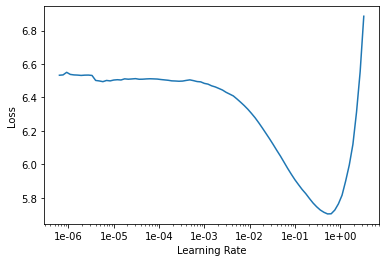

In [60]:
learn.lr_find() #start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

We pick something closer to the point where the loss is the lowest.

**Run the language model class learner**

In [61]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.942539,4.220109,0.226135,00:16


**Unfreeze the entire model**

In [62]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.960122,3.857833,0.272061,00:21
1,3.771551,3.729600,0.281827,00:20
2,3.554533,3.758404,0.278999,00:20
3,3.253327,3.815828,0.279669,00:20
4,2.888376,3.990829,0.263895,00:20
5,2.447361,4.120611,0.266760,00:20
6,1.905068,4.347198,0.264658,00:20
7,1.414909,4.503414,0.262816,00:20
8,1.095676,4.563406,0.262835,00:20
9,0.913355,4.580797,0.262407,00:20


In [63]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

**Classification Dataloader**

In [64]:
# Classifier model data
data_class = TextClasDataBunch.from_df(path, df_train, df_val, df_test, text_cols='text', label_cols='labels',vocab=data_lm.vocab) #, min_freq=1, bs=32)
data_class.save()

In [65]:
data_class.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,1
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,0
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup xxunk up here this xxup am .. so i understand .. xxmaj btw xxup xxunk is my xxmaj airline when i m able to xxunk .. xxmaj love you guys . : ),2
"xxbos @southwestair xxmaj loved one 's flight xxup atl to xxup ind xxmaj cancelled xxmaj flightled due to "" ice in xxmaj indy "" . xxmaj sitting here in xxmaj indy , it is xxunk dry . xxmaj tomorrow 4 - 6 "" of snow .",0
xxbos @americanair xxmaj took a flight yesterday xxunk xxup tpa - xxup dfw - xxup aus . xxmaj bag went to xxup iah . xxmaj today bag went to xxup iah - xxup dfw and then back to xxup iah . xxmaj still no bag !,0


In [66]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
#learn.freeze()

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8198 items)
x: TextList
xxbos @usairways i called more than 25 times to redeem mile points and ca n't get through . xxmaj you advertise the miles but make them very hard to use !,xxbos @united - thanks for the rude customer service and 3 hour delay . xxmaj it really helped me timing xxunk for my afternoon meetings . xxmaj hello @delta !,xxbos @united is really getting horrible . xxmaj so much for xxunk in my kids tonight . xxmaj delta xxunk miles / status , right ? http : / / t.co / xxup xxunk,xxbos @usairways xxmaj joined xxmaj silver xxmaj preferred because i heard customer service was so great , pity i was xxunk .,xxbos @usairways thank you
y: CategoryList
0,0,0,0,1
Path: .;

Valid: LabelList (2050 items)
x: TextList
xxbos @jetblue i would like to communicate directly with a " xxmaj customer xxmaj experience " executive . xxmaj does xxmaj xxunk xxmaj xxunk have an email address ?,xxbos @usairways of course weather was a joke xxun

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


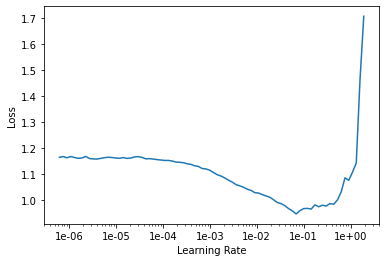

In [67]:
learn.lr_find() #start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

**Train the Classifer**

In [68]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.646921,0.571774,0.769268,00:09


We chose a learning quite smaller than the one showed in the graph and the accuracy has shot up to 76% which is an improvement than the supervised models which barely shows 70%.

In [69]:
learn.freeze_to(-2)
#learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.579105,0.516814,0.792683,00:12


In [70]:
learn.freeze_to(-3)
#learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.524770,0.510852,0.793171,00:18


In [71]:
#unfreezing everything after the 3 layers
learn.unfreeze()
#learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.464073,0.503015,0.797561,00:24
1,0.444183,0.508187,0.797073,00:22
2,0.428954,0.510478,0.797561,00:22
3,0.410052,0.512665,0.797073,00:24
4,0.369297,0.520997,0.801951,00:24
5,0.329745,0.535806,0.800488,00:24
6,0.302033,0.544012,0.799512,00:23
7,0.304835,0.570180,0.801951,00:22
8,0.291987,0.545289,0.798537,00:23
9,0.274296,0.546391,0.796098,00:25


This is a great result because w got an accuracy close to 80%

**Testing the Model**

In [72]:
learn.predict('your airline is very bad. The worst service')

(Category tensor(0), tensor(0), tensor([0.9861, 0.0012, 0.0127]))

In [73]:
learn.predict('your airline is very good. I enjoyed the service very much')

(Category tensor(2), tensor(2), tensor([0.3259, 0.0040, 0.6701]))

**Predictions**

In [74]:
df_test['Predictions'] = df_test['text'].apply(lambda row: str(learn.predict(row)[0]))

In [78]:
df_test.head(6)

,text,labels,Predictions
12814,@AmericanAir I'll try to have a great week onc...,0,2
1490,@united You suck. Flight delayed equipment pro...,0,0
12460,@AmericanAir is it right to provide faulty sea...,0,1
2824,@united this is besides the fact that one week...,0,0
10782,"@USAirways Yes, it was Sunday.",1,1
8420,@JetBlue OH YEAH!!! great flight down to Mexic...,2,2


In [82]:
type(df_test['labels'].values[0])

numpy.int64

In [86]:
type(df_test['Predictions'].values[0])

numpy.int64

In [85]:
df_test['Predictions'] = [int(x) for x in df_test['Predictions']]

In [87]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(df_test['labels'], df_test['Predictions']))
#pd.DataFrame(confusion_matrix(Y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2753
           1       0.66      0.67      0.66       930
           2       0.74      0.71      0.73       709

    accuracy                           0.81      4392
   macro avg       0.76      0.75      0.76      4392
weighted avg       0.81      0.81      0.81      4392



This is the final report, the accuracy and overall performance of the classifier has improved greatly.

#Basic ULM Fit Implementation

In [ ]:
# split data into training and validation set
#df_trn, df_val = train_test_split(data, stratify = data['label_encoded'], test_size = 0.4, random_state = 12)
#df_trn, df_val = train_test_split(data, stratify = data['label_encoded'], test_size = 0.2, random_state = 42)
df_trn, df_val = train_test_split(new_data, stratify = new_data['label_encoded'], test_size = 0.3, random_state = 42)

In [ ]:
df_trn.shape, df_val.shape

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)


In [ ]:
data_lm

In [ ]:
learn = language_model_learner(data_lm,arch = AWD_LSTM, pretrained = True, drop_mult=0.7)

In [ ]:
# train the learner object
learn.fit_one_cycle(1, 1e-2)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.save_encoder('ft_enc')

In [ ]:
learn = text_classifier_learner(data_clas,arch = AWD_LSTM, pretrained = True, drop_mult=0.7)
learn.load_encoder('ft_enc')

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2)


In [ ]:
#oversampled dataset
learn.fit_one_cycle(1, 1e-2)


In [ ]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)


In [ ]:
#oversampled dataset
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)


In [ ]:
#oversampled dataset
print(classification_report(targets, predictions))
#pd.DataFrame(confusion_matrix(Y_test, y_pred))


In [ ]:
print(classification_report(targets, predictions))
#pd.DataFrame(confusion_matrix(Y_test, y_pred))


In [ ]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)


In [ ]:
print(classification_report(targets, predictions))
#pd.DataFrame(confusion_matrix(Y_test, y_pred))


The precision of prediction has improved but the problem still remains - the imbalanced dataset

oversampling fails too